In [1]:
checkpoint = 'axial_segmentation_detection_115656-epoch-31.pth'

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import math
from tqdm import tqdm

from PIL import Image, ImageOps

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF
import torchvision.models as models

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, f"train_axial_images_jpeg95")
LABEL_DIR = os.path.join(DATA_DIR, f"segmentation_axial_labels")

In [5]:
class DetectionModel(nn.Module):
    def __init__(self, backbone, channels, deep=4, out_channels=64, n_features=1):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels
        self.out_channels = out_channels
        self.n_features = n_features

        self.init_layers()

    def init_layers(self):
        self.parallel_modules = self.make_parallel_modules()
        self.upsampling_modules = self.make_upsampling_modules()

        self.downsampling_modules = self.make_downsampling_modules()
        self.classification_modules = self.make_classification_modules()

    def make_classification_modules(self):
        # the last layer
        return nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(self.out_channels, 2 * self.out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(2 * self.out_channels, self.n_features, kernel_size=1, padding='same'),
        )

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(self.channels[i], self.channels[i], kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i], kernel_size=1, padding='same'),
            )
            parallel_modules.append(module)


        return parallel_modules

    def make_downsampling_modules(self):
        return nn.ModuleList([
            nn.Sequential(
                self.backbone.conv1,
                self.backbone.bn1,
                self.backbone.relu,
                self.backbone.maxpool),
            nn.Sequential(
                self.backbone.layer1,
                self.backbone.layer2,
            ),
            self.backbone.layer3,
            self.backbone.layer4
        ])

    def make_upsampling_modules(self):
        upsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i] // 2, kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i] // 2, self.channels[i-1] if i > 0 else self.out_channels, kernel_size=1),
                nn.Upsample(scale_factor=2)
            )
            upsampling_modules.append(module)

        return upsampling_modules



    def forward(self, x):

        downsampling_outputs = []
        out = x
        for module in self.downsampling_modules:
            out = module(out)
            downsampling_outputs.append(out)

        parallel_outputs = []
        for i in range(len(self.parallel_modules)):
            module = self.parallel_modules[i]
            out = module(downsampling_outputs[i])
            parallel_outputs.append(out)

        out = 0
        for i in range(len(self.upsampling_modules)):
            module = self.upsampling_modules[-(i+1)]
            parallel_output = parallel_outputs[-(i+1)]

            up_input = out + parallel_output
            out = module(up_input)

        out = self.classification_modules(out)

        return out


def resnet50_gray():
    model = models.resnet50(pretrained=False)
    conv1_weight = model.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return model

def get_axial_segmentation_model(checkpoint):
    backbone = resnet50_gray()
    channels = [64, 512, 1024, 2048]
    model = DetectionModel(backbone, channels=channels, out_channels=channels[0], n_features=2).to(device)
    
    state = torch.load(os.path.join(DATA_DIR, 'checkpoint', checkpoint))
    model.load_state_dict(state["model"])
    model.eval()
    return model

model = get_axial_segmentation_model(checkpoint)


/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
UID = '1.2.826.0.1.3680043.1573'
axial_index = 205
label = Image.open(os.path.join(LABEL_DIR, UID, f"{axial_index}.png"))
label = np.array(label) / 256

print(label.min(), label.max())

0.0 0.875


6.0

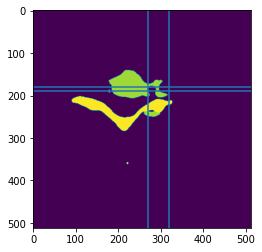

In [7]:
def get_bbox_class(label, bbox):
    """
    label 은 0.125 의 단위로, 
    bbox: [xmin, ymin, xmax, ymax]
    """
    xmin, ymin, xmax, ymax = bbox
    area = label[ymin:ymax, xmin:xmax]
    
    plt.imshow(label)
    plt.axvline(xmin)
    plt.axvline(xmax)
    plt.axhline(ymin)
    plt.axhline(ymax)
    # print(area)
    result = np.mean(area[area>0])
    result = np.round(result / 0.125)
    
    return result

get_bbox_class(label, [270, 180, 320, 190])

In [23]:
def get_axial_boundary(seg, pixel_spacing, throw=100, tol=0.2, max_mm=100):
    image_size = seg.shape[0]
    min_size = min(image_size, max_mm / pixel_spacing)
    
    rows, columns = seg.nonzero()
    rows.sort()
    columns.sort()
    
    throw = min(len(rows) // 2, throw)
    
    if(len(rows)) == 0:
        return 0, 0, image_size, image_size
    
    xmin, xmax = columns[throw], columns[-throw]
    ymin, ymax = rows[throw], rows[-throw]
    
    w = (xmax - xmin) * (1 + tol)
    h = (ymax - ymax) * (1 + tol)
    new_size = max(w, h, min_size)
    new_size = min(image_size, new_size)
    
    xcenter, ycenter = (xmax + xmin) / 2, (ymax + ymin) / 2
    
    xmin = min(image_size - new_size, xcenter - new_size / 2)
    xmin = max(0, xmin)
    
    ymin = min(image_size - new_size, ycenter - new_size / 2)
    ymin = max(0, ymin)
    
    return xmin, ymin, xmin + new_size, ymin + new_size

UID = '1.2.826.0.1.3680043.10062'


_, axs = plt.subplots(28, 10, figsize=(100, 280))

for i in range(280):
    
    axial_index = i
    label = Image.open(os.path.join(LABEL_DIR, UID, f"{axial_index}.png"))
    label = np.array(label) / 256
    xmin, ymin, xmax, ymax = get_axial_boundary(label, 0.2539)
    axs[i//10, i % 10].imshow(label)
    axs[i//10, i % 10].axvline(xmin)
    axs[i//10, i % 10].axvline(xmax)
    axs[i//10, i % 10].axhline(ymin)
    axs[i//10, i % 10].axhline(ymax)

FileNotFoundError: [Errno 2] No such file or directory: '/root/autodl-tmp/cervical_spine/segmentation_axial_labels/1.2.826.0.1.3680043.10062/0.png'

In [9]:
class DataTransform(nn.Module):
    def __init__(self, image_size):
        super().__init__()

        self.image_size = image_size

        
        self.transform = A.Compose([
            A.Resize(image_size, image_size),
            ToTensorV2(p=1),
        ])

        self.normalize = T.Normalize(255 * 0.5, 255 * 0.5)

    def forward(self, x):
        augmented = self.transform(image=np.asarray(x))
        x= augmented['image']

        x = self.normalize(x.float())

        return x
    
transform = DataTransform(256)

In [10]:
@torch.no_grad()
def predict(x, model):
    x = x.to(device)
    logits = model(x)

    classification_score, mse_score = logits.sigmoid().chunk(2, dim=1)
    classification_pred = classification_score.gt(0.5).float()
    pred = (classification_pred * mse_score).cpu().numpy()
    
    return pred

tensor(-0.9216, device='cuda:0') tensor(0.9922, device='cuda:0')
torch.Size([1, 1, 256, 256])
0.0 0.6389199


(41.0474006116208, 16.5474006116208, 193.9525993883792, 169.4525993883792)

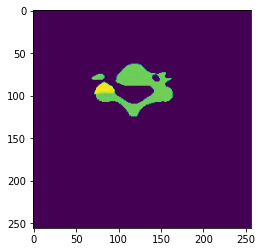

In [20]:
img = Image.open(os.path.join(IMAGES_DIR, UID, '156.jpeg'))
x = transform(img).unsqueeze(0).to(device)
print(x.min(), x.max())
print(x.shape)
label = predict(x, model)
print(label.min(), label.max())

plt.imshow(label.squeeze())
get_axial_boundary(label.squeeze(), 0.327, throw=50, tol=0.2, max_mm=50)

In [28]:
train_3d_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_train_3d.csv')).set_index('UID')
print(len(train_3d_df))
train_3d_df.head()

1983


,z_spacing,pixel_spacing,aspect,is_flip,z_height
UID,,,,,
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461540885209487,0,268
1.2.826.0.1.3680043.10005,0.625,0.298828,2.0915041428514063,0,259
1.2.826.0.1.3680043.10014,0.8000000000000114,0.234,3.418803418803467,0,258
1.2.826.0.1.3680043.10016,0.3130000000000024,0.275391,1.136565828222427,0,645
1.2.826.0.1.3680043.10032,0.625,0.320313,1.9512164663938085,0,321


In [30]:
UID = '1.2.826.0.1.3680043.15105'
pixel_spacing = float(train_3d_df.loc[UID, 'pixel_spacing'])

_, axs = plt.subplots(28, 10, figsize=(100, 280))

class_label_list = []

for i in tqdm(range(280)):
    axial_index = i
    img = Image.open(os.path.join(IMAGES_DIR, UID, f'{i}.jpeg'))
    x = transform(img).unsqueeze(0).to(device)
    label = predict(x, model)
    label = np.round(label / 0.125) * 0.125
    label = label.squeeze()
    class_label = np.mean(label[label > 0])
    class_label_list.append(class_label)
    xmin, ymin, xmax, ymax = get_axial_boundary(label, pixel_spacing, throw=50, tol=0.2, max_mm=50)
    axs[i//10, i % 10].imshow(label, cmap='nipy_spectral')
    axs[i//10, i % 10].axvline(xmin)
    axs[i//10, i % 10].axvline(xmax)
    axs[i//10, i % 10].axhline(ymin)
    axs[i//10, i % 10].axhline(ymax)
    axs[i//10, i % 10].set_title(class_label)

  0%|          | 0/280 [00:00<?, ?it/s]/root/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 280/280 [00:13<00:00, 20.59it/s]


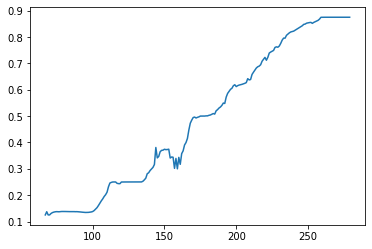

In [31]:
plt.plot(class_label_list)